In [331]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [332]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [333]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime
from datetime import timedelta

# just set the seed for the random number generator
#np.random.seed(107)

In [334]:
# interval to get ohlc data from binance
# DON'T CHANGE
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
interval = '1m'

# Change...
pair = 'BTCUSDT'
#pairs = ['BTCUSDT', 'ETHUSDT','ADAUSDT','CHZUSDT','ENJUSDT','LINKUSDT','FILUSDT','XRPUSDT']
#pairs = ['ETHBTC','ADABTC','CHZBTC','ENJBTC','LINKBTC','FILBTC','XRPBTC']
# interval used to compute indicators and backtest analysis
# valid strategy intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
strategy_interval = '1D'
# date to start analysis
dt_start_analysis = '2021-1-1'

In [335]:
from trade_utils import initialize_ohlc_df

try:
    df = pd.read_csv('data/' + pair + '-' + interval + '-binance-all.csv')
    df['OpenTime'] = pd.to_datetime(df['OpenTime'])
    df.set_index('OpenTime', inplace=True)
except FileNotFoundError:
    df = initialize_ohlc_df()


In [336]:
df.shape

(2049138, 5)

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049138 entries, 2017-08-17 04:00:00 to 2021-07-26 16:54:00
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   OpenPrice   float64
 1   HighPrice   float64
 2   LowPrice    float64
 3   ClosePrice  float64
 4   Volume      float64
dtypes: float64(5)
memory usage: 93.8 MB


In [338]:
df.head()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796


In [339]:
df.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-07-26 16:50:00,39037.69,39074.35,39007.73,39031.02,106.878252
2021-07-26 16:51:00,39031.02,39083.27,39025.66,39055.49,52.129415
2021-07-26 16:52:00,39055.49,39135.85,39045.01,39061.60,82.106015
2021-07-26 16:53:00,39061.60,39134.99,39061.59,39115.93,45.468556
2021-07-26 16:54:00,39115.93,39140.76,39100.00,39139.18,27.973397


In [340]:
from binance_utils import update_historical_data

df = update_historical_data(df, pair, interval)

In [341]:
# save all data
filename = 'data/' + pair + '-' + interval + '-binance-all.csv'
df.to_csv(filename)

# reduce data from 2020 until now
df = df['2020-1-1':]
filename = 'data/' + pair + '-' + interval + '-binance.csv'
df.to_csv(filename)


In [342]:
summaries = {'OpenPrice': 'first', 'HighPrice': 'max', 'LowPrice': 'min', 'ClosePrice': 'last', 'Volume': 'sum'}

# valid intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
if strategy_interval == '1min':
    data = df.copy()
else:
    data = df.resample(strategy_interval).agg(summaries)
    data.dropna(inplace=True)

In [343]:
data.sample(10)

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2020-11-24,18368.01,19418.97,18018.00,19160.01,113581.509241
2020-03-14,5576.05,5640.52,5055.13,5172.06,136910.135974
2020-07-30,11100.52,11170.00,10831.00,11099.61,60794.826456
2020-04-12,6876.84,7177.00,6780.00,6903.79,73868.666501
2020-04-15,6868.57,6933.00,6605.00,6621.24,61571.384994
2020-11-13,16291.85,16480.00,15952.35,16320.70,75691.881014
2020-06-26,9249.49,9298.00,9045.45,9162.21,50292.298277
2020-11-29,17719.84,18360.05,17517.00,18184.99,55329.016303
2021-06-25,34663.08,35500.00,31275.00,31584.45,116061.130356


In [344]:
from technical_indicator_utils import sma, ema, macd, rsi, adx, bbands

# Calculate daily returns
data['daily_return'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous day

# SMA
data['SMA5'] = sma(data['ClosePrice'], 5)
data['SMA10'] = sma(data['ClosePrice'], 10)
data['SMA20'] = sma(data['ClosePrice'], 20)
data['SMA30'] = sma(data['ClosePrice'], 30)
data['SMA50'] = sma(data['ClosePrice'], 50)
data['SMA100'] = sma(data['ClosePrice'], 100)
data['SMA200'] = sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = ema(data['ClosePrice'], 5)
data['EMA10'] = ema(data['ClosePrice'], 10)
data['EMA20'] = ema(data['ClosePrice'], 20)
data['EMA30'] = ema(data['ClosePrice'], 30)
data['EMA50'] = ema(data['ClosePrice'], 50)
data['EMA100'] = ema(data['ClosePrice'], 100)
data['EMA200'] = ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['MACDSignal'], data['MACDHist'] = macd(data.ClosePrice)

# RSI
data['rsi'] = rsi(data.ClosePrice)

# ADX
data['DI+'], data['DI-'], data['ADX'] = adx(data.HighPrice, data.LowPrice, data.ClosePrice)

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = bbands(data.ClosePrice)

In [345]:
#limit data to plot
data = data[dt_start_analysis:]

In [346]:
from technical_indicator_utils import fibonacci_retracement_levels

# Fibonacci retracement
fib_levels = fibonacci_retracement_levels(data['ClosePrice'].max(), data['ClosePrice'].min())

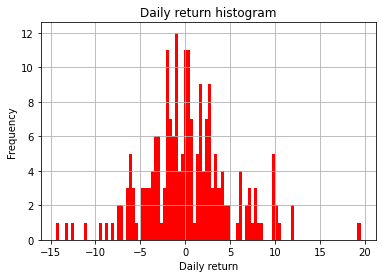

In [347]:
# Plot the histogram
data['daily_return'].hist(bins=100, color='red')
plt.ylabel('Frequency')
plt.xlabel('Daily return')
plt.title('Daily return histogram')
plt.show()

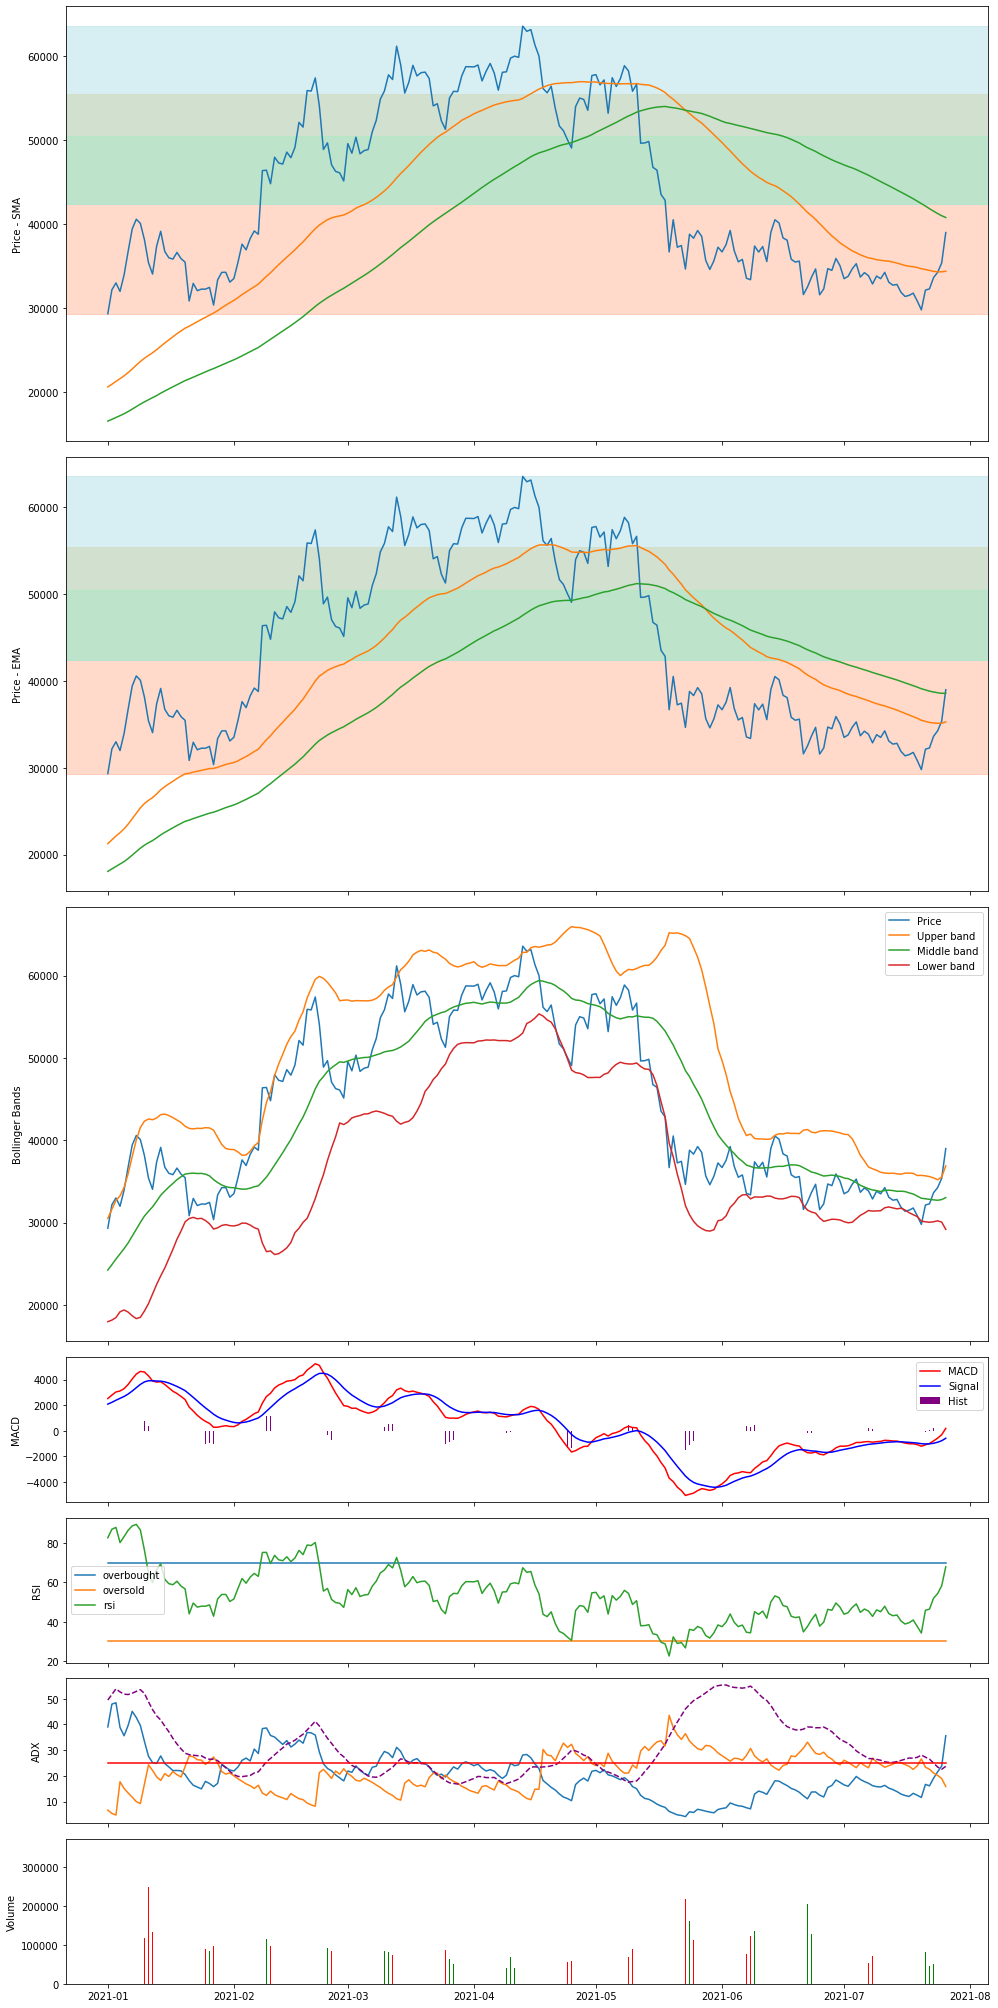

In [348]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, sharex=True, figsize=(14, 28), gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]})

# Price x SMA
ax1.plot(data.index, data[['ClosePrice', 'SMA50', 'SMA100']])
# Fibonacci retracement
ax1.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax1.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax1.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax1.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax1.set_ylabel('Price - SMA')

# Price x EMA
ax2.plot(data.index, data[['ClosePrice', 'EMA50', 'EMA100']])
# Fibonacci retracement
ax2.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax2.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax2.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax2.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax2.set_ylabel('Price - EMA')

# Bollinger Bands
ax3.plot(data['ClosePrice'], label='Price')
ax3.plot(data['UpperBBand'], label='Upper band')
ax3.plot(data['MidiBBand'], label='Middle band')
ax3.plot(data['LowerBBand'], label='Lower band')
ax3.legend()
ax3.set_ylabel('Bollinger Bands')

# MACD
ax4.plot(data.index, data['MACD'], label='MACD', color = 'red')
ax4.bar(data.index, data['MACDHist'], label='Hist', color="purple", width = timedelta(hours=1))
ax4.plot(data.index, data['MACDSignal'], label='Signal', color='blue')
ax4.legend()
ax4.set_ylabel('MACD')

# RSI
ax5.plot(data.index, [70] * len(data.index), label='overbought')
ax5.plot(data.index, [30] * len(data.index), label='oversold')
ax5.plot(data.index, data['rsi'], label='rsi')
ax5.legend()
ax5.set_ylabel('RSI')

# ADX
ax6.plot(data.index, data[['DI+', 'DI-']])
ax6.plot(data.index, data[['ADX']], color='purple', linestyle='dashed')
ax6.plot(data.index, [25] * len(data.index), color = 'red')
ax6.set_ylabel('ADX')

# Volume
# make bar plots and color differently depending on up/down for the day
pos = data['OpenPrice'] - data['ClosePrice'] < 0
neg = data['OpenPrice'] - data['ClosePrice'] > 0
ax7.bar(data.index[pos], data[pos]['Volume'], color='green', width = timedelta(hours=1))
ax7.bar(data.index[neg], data[neg]['Volume'], color='red', width = timedelta(hours=1))

#ax7.bar(data.index, data['Volume'] / 1000000, width = timedelta(hours=4))
ax7.set_ylabel('Volume')

fig.tight_layout()

## Backtest Strategy

In [349]:
import bt

# Get the price data
price_data = data[['ClosePrice']].copy()

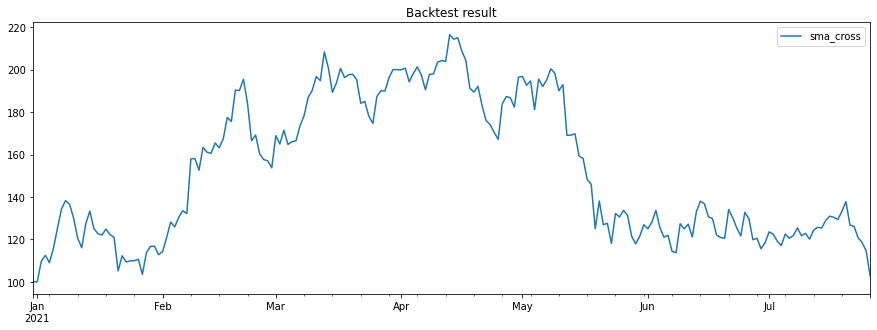

In [350]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['SMA50']].copy(), data[['SMA200']].copy())
bt_sma_cross = signal_strategy(price_data.copy(), signal, 'sma_cross')

bt_result = bt.run(bt_sma_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

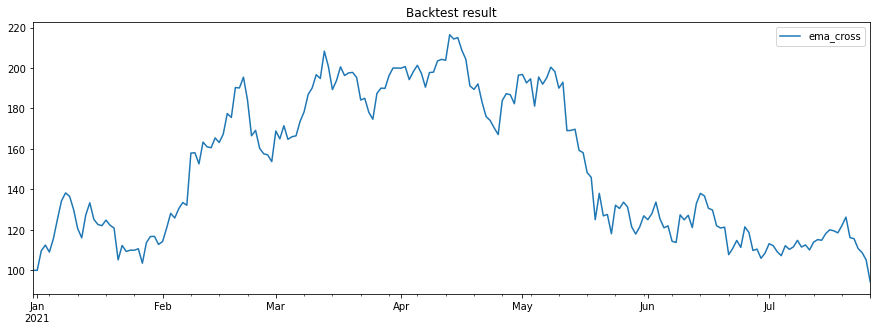

In [351]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['EMA50']].copy(), data[['EMA200']].copy())
bt_ema_cross = signal_strategy(price_data.copy(), signal, 'ema_cross')

bt_result = bt.run(bt_ema_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

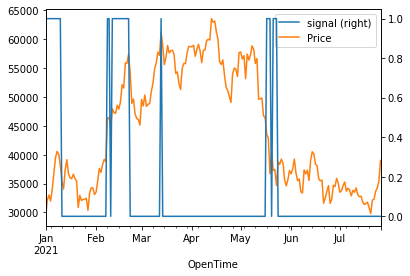

In [352]:
from backtest_utils import get_rsi_signal, signal_strategy

signal = get_rsi_signal(data[['rsi']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

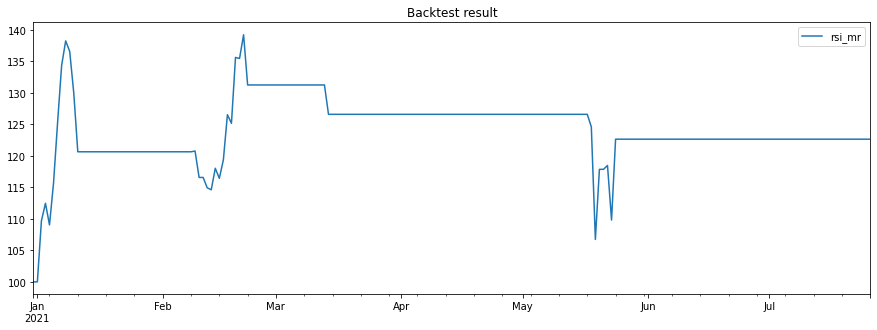

In [353]:
bt_rsi = signal_strategy(price_data.copy(), signal, 'rsi_mr')

bt_result = bt.run(bt_rsi)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

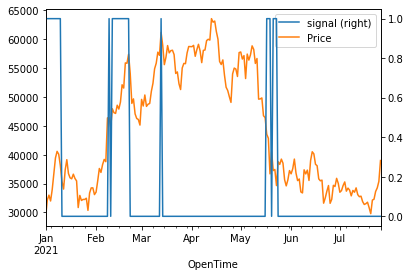

In [354]:
from backtest_utils import get_rsi_adx_signal, signal_strategy

signal = get_rsi_adx_signal(data[['rsi']].copy(), data[['ADX']])

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

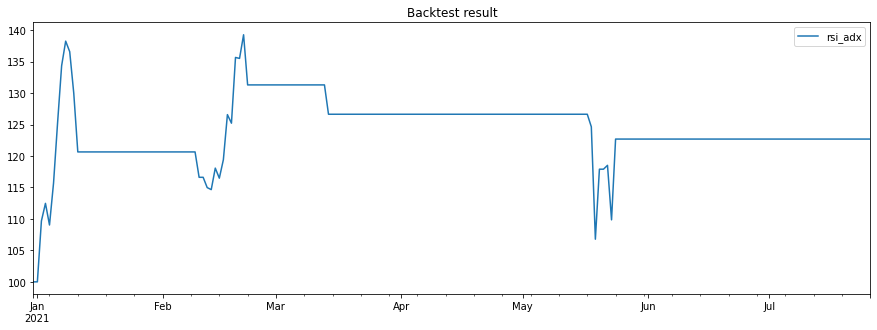

In [355]:
bt_rsi_adx = signal_strategy(price_data.copy(), signal, 'rsi_adx')

bt_result = bt.run(bt_rsi_adx)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

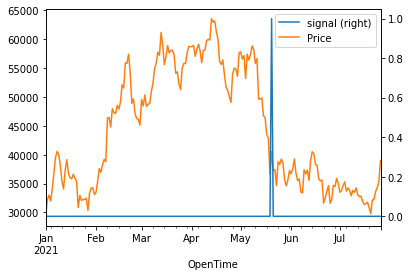

In [356]:
from backtest_utils import get_rsi_plus_signal, signal_strategy

signal = get_rsi_plus_signal(data[['rsi']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

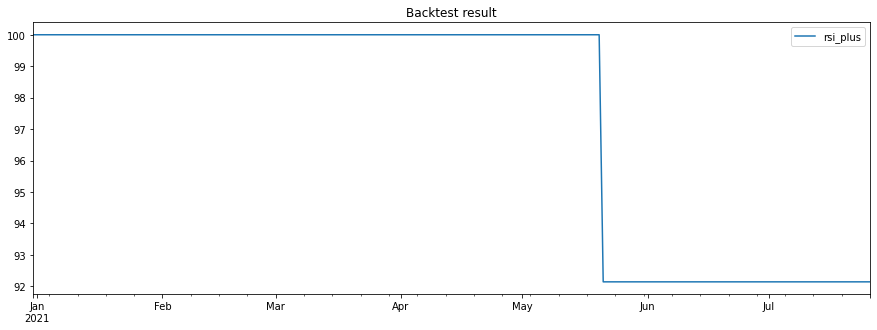

In [357]:
bt_rsi_plus = signal_strategy(price_data.copy(), signal, 'rsi_plus')

bt_result = bt.run(bt_rsi_plus)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

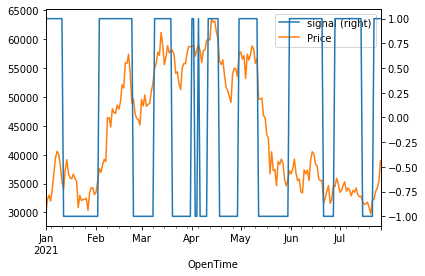

In [358]:
from backtest_utils import get_macd_signal, signal_strategy

signal = get_macd_signal(data[['MACDSignal']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

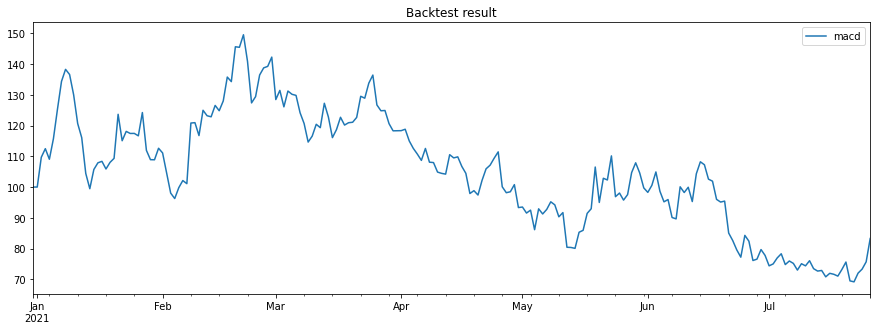

In [359]:
bt_macd = signal_strategy(price_data.copy(), signal, 'macd')

bt_result = bt.run(bt_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

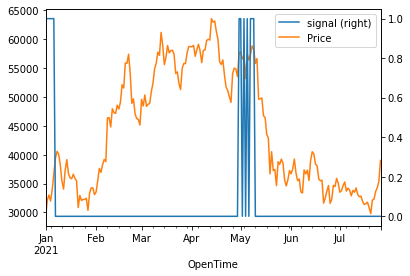

In [360]:
from backtest_utils import get_sma_macd_signal, signal_strategy

signal = get_sma_macd_signal(data[['ClosePrice']].copy(), data[['SMA50']].copy(), data[['SMA100']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

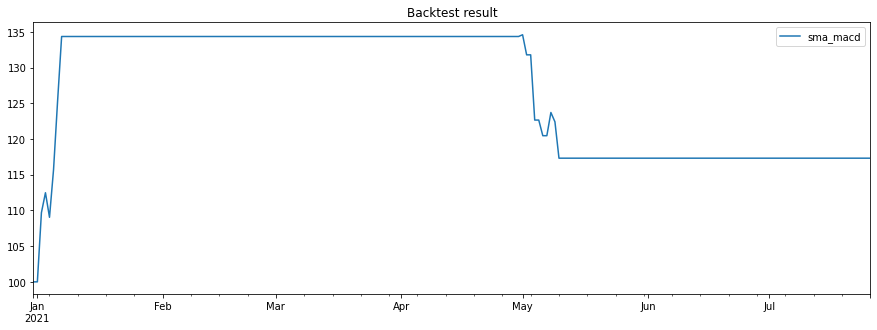

In [361]:
bt_sma_macd = signal_strategy(price_data.copy(), signal, 'sma_macd')

bt_result = bt.run(bt_sma_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [362]:
from backtest_utils import signal_above_strategy, buy_and_hold_strategy

# Create signal strategy backtest
bt_sma5 = signal_above_strategy(price_data.copy(), data[['SMA5']].copy(), name='SMA5')
bt_sma10 = signal_above_strategy(price_data.copy(), data[['SMA10']].copy(), name='SMA10')
bt_sma20 = signal_above_strategy(price_data.copy(), data[['SMA20']].copy(), name='SMA20')
bt_sma30 = signal_above_strategy(price_data.copy(), data[['SMA30']].copy(), name='SMA30')
bt_sma50 = signal_above_strategy(price_data.copy(), data[['SMA50']].copy(), name='SMA50')
bt_sma100 = signal_above_strategy(price_data.copy(), data[['SMA100']].copy(), name='SMA100')

# Create benchmark strategy backtest
bt_benchmark = buy_and_hold_strategy(price_data.copy(), name='benchmark')

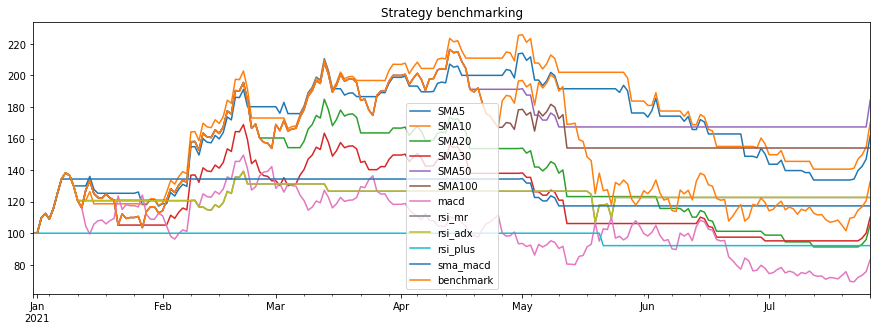

In [363]:
# Run all backtests and plot the resutls
bt_results = bt.run(bt_sma5,bt_sma10, bt_sma20, bt_sma30, bt_sma50, bt_sma100, bt_macd, bt_rsi, bt_rsi_adx, bt_rsi_plus, bt_sma_macd, bt_benchmark)
#bt_results = bt.run(bt_rsi, bt_sma50, bt_benchmark)
bt_results.plot(title='Strategy benchmarking')
plt.show()

In [364]:
bt_results.display()

Stat                 SMA5        SMA10       SMA20       SMA30       SMA50       SMA100      macd        rsi_mr      rsi_adx     rsi_plus    sma_macd    benchmark
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------
Start                2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31
End                  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         61.81%      70.06%      5.80%       10.18%      84.32%      53.99%      -16.72%     22.65%      22.69%      -7.86%      17.31%      32.86%
Daily Sharpe         1.4

In [365]:
# Obtain all backtest stats
resInfo = bt_results.stats
print(resInfo.loc['total_return'].sort_values(ascending=False))

best_strategy = ''
best_total_return = -1
for strategy, total_return in zip(resInfo.loc['total_return'].index, resInfo.loc['total_return'].values):
    if total_return > best_total_return:
        best_total_return = total_return
        best_strategy = strategy

bt_best = bt_results.backtests[best_strategy]
print('Best Strategy: ' + best_strategy)

SMA50        0.843152
SMA10        0.700587
SMA5         0.618087
SMA100       0.539891
benchmark    0.328592
rsi_adx       0.22691
rsi_mr       0.226481
sma_macd     0.173093
SMA30        0.101785
SMA20        0.058025
rsi_plus    -0.078591
macd        -0.167154
Name: total_return, dtype: object
Best Strategy: SMA50


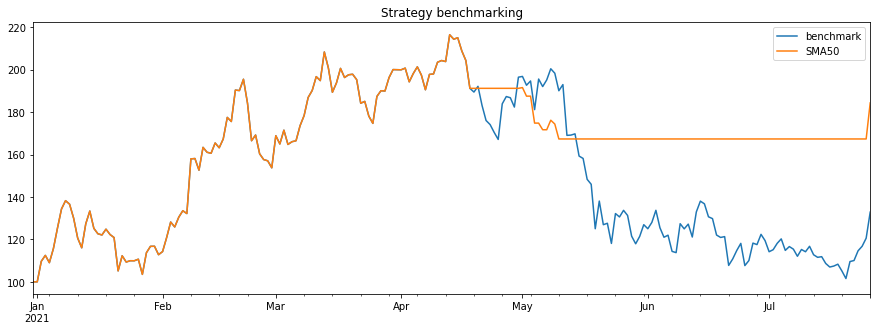

In [366]:
bt_results_best = bt.run(bt_benchmark, bt_best)
bt_results_best.plot(title='Strategy benchmarking')
plt.show()

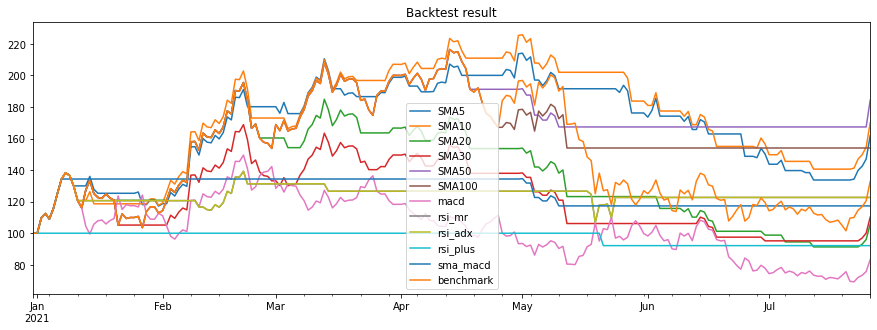

          SMA5    SMA10    SMA20    SMA30    SMA50   SMA100     macd  rsi_mr  \
mtd      7.75%    8.66%    7.09%   15.78%   10.15%    0.00%    7.06%   0.00%   
3m     -19.10%  -19.37%  -31.13%  -20.14%   -3.59%   -7.85%  -16.79%  -3.12%   
6m      28.30%   43.35%  -12.46%    4.77%   66.56%   39.15%  -28.60%   1.66%   
ytd     61.81%   70.06%    5.80%   10.18%   84.32%   53.99%  -16.72%  22.65%   
1y        nan%     nan%     nan%     nan%     nan%     nan%     nan%    nan%   
3y        nan%     nan%     nan%     nan%     nan%     nan%     nan%    nan%   
5y        nan%     nan%     nan%     nan%     nan%     nan%     nan%    nan%   
10y       nan%     nan%     nan%     nan%     nan%     nan%     nan%    nan%   
incep  133.77%  155.21%   10.46%   18.65%  194.16%  114.20%  -27.58%  43.36%   

      rsi_adx rsi_plus sma_macd benchmark  
mtd     0.00%    0.00%    0.00%    11.25%  
3m     -3.12%   -7.86%  -12.68%   -27.75%  
6m      1.69%   -7.86%  -12.68%    20.06%  
ytd    22.69%   -7.86% 

In [367]:
# Plot the backtest result
bt_results.plot(title='Backtest result')
plt.show()

# Get the lookback returns
lookback_returns = bt_results.display_lookback_returns()
print(lookback_returns)

# Tests

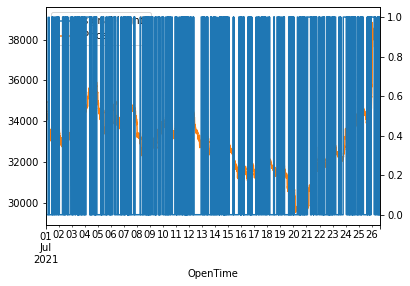

In [368]:
from backtest_utils import get_5_minute_signal, signal_strategy
import bt

data_5m = df_5m.copy()
data_5m['MACD'], data_5m['MACDSignal'], data_5m['MACDHist'] = macd(data_5m.ClosePrice)
data_5m['EMA20'] = ema(data_5m['ClosePrice'], 20)
data_5m = data_5m['2021-7-1':]

signal = get_5_minute_signal(data_5m[['ClosePrice']].copy(), data_5m[['MACD']].copy(), data_5m[['EMA20']].copy())

# Merge the data
combined_df = bt.merge(signal, data_5m[['ClosePrice']])
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


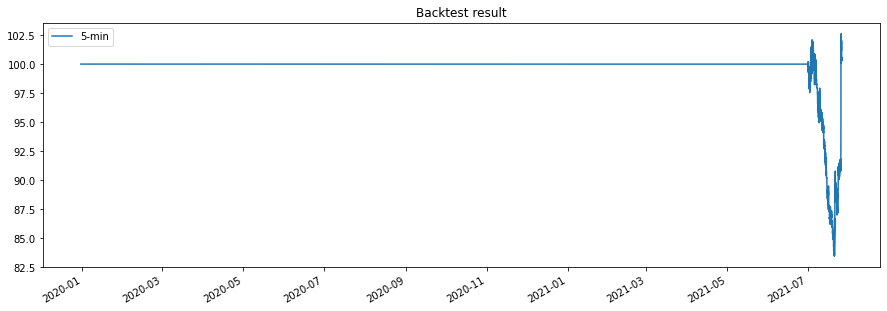

In [369]:
bt_backtest = signal_strategy(df_5m[['ClosePrice']].copy(), signal, '5-min')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()